In [1]:
import sys
from src import model, visualization, evaluate, data
import src.lib.useful_functions as uf


import numpy as np
import yaml
# import pandas as pd

In [2]:
#RUN ONLY TO SAVE IMAGES LOCALLY

# data.save_imgs_2npy(meta_path='data/meta',
#             mk_folder_path='data/C02-MK/2020',
#             img_folder_path='data/C02-FR/2020',
#             destintation_path='data/images',
#             split_days_into_folders=True
#     )

In [2]:
#LOAD WHOLE DAY 
images_20, timestamp_20 = data.load_images_from_folder('data/images/dia_20',crop_region = 3)
#images_91, timestamp_91 = data.load_images_from_folder('data/images/dia_91',crop_region = 3)

In [4]:
#TEST persistence RETURN
persistence = model.Persistence()
predictions, predict_ts = persistence.predict(images_20[80], timestamp_20[80], predict_horizon = 5)
print('persistence returned', len(predictions), 'images')
print('timestamp of input image',timestamp_20[80])
print('timestamp of predicted images', predict_ts)

persistence returned 6 images
timestamp of input image 2020-01-20 13:20:17
timestamp of predicted images DatetimeIndex(['2020-01-20 13:20:17', '2020-01-20 13:30:17',
               '2020-01-20 13:40:17', '2020-01-20 13:50:17',
               '2020-01-20 14:00:17', '2020-01-20 14:10:17'],
              dtype='datetime64[ns]', freq='10T')


In [7]:
#TEST evaluate.evaluate_image RETURN

predict_errors = evaluate.evaluate_image(predictions, images_20[80:86], metric='FS',  pixel_max_value =255)
print('error comparing with images in ground truth' , predict_errors)


error comparing with images in ground truth [1, 0.0, 0.0, 0.0, 0.0, 0.0]


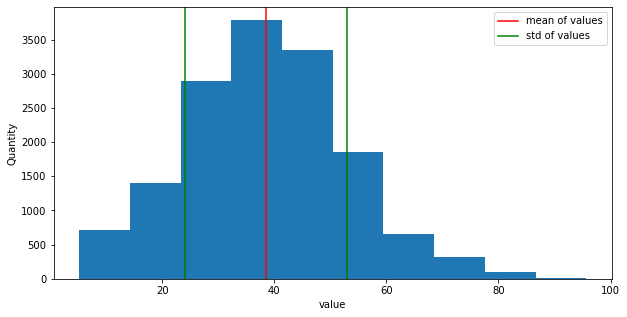

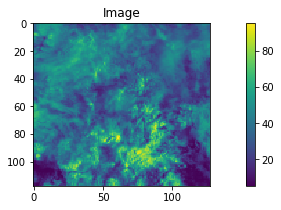

In [14]:
visualization.plot_histogram(images_20[80],bins=10,normalize=False)
visualization.show_image_w_colorbar(images_20[80])

In [69]:
#ERROR CALCULATOR WHEN WHOLE DAY LOADED

predict_horizon = 10
error_p_list =[] #used for persistence
error_bp_list =[] #used for blurred persistence
 
 

for i in range(len(images_20)):
    if (i < len(images_20)-predict_horizon):
        predictions_p, _ = model.persitence(images_20[i], timestamp_20[i], predict_horizon)
        predictions_bp, _ = model.blurred_persitence(images_20[i], timestamp_20[i], predict_horizon,kernel_size=(11,11))
        
        
        predict_errors_p = evaluate.evaluate_image(predictions_p, images_20[i+1:i+predict_horizon+1], 
                                                metric='FS',  pixel_max_value =255)
        predict_errors_bp = evaluate.evaluate_image(predictions_bp, images_20[i+1:i+predict_horizon+1], 
                                                metric='FS',  pixel_max_value =255)
        
    else: #starts predicting images outside the day
        
        predictions_p, _ = model.persitence(images_20[i], timestamp_20[i], len(images_20)-(i+1))
        predictions_bp, _ = model.blurred_persitence(images_20[i], timestamp_20[i], len(images_20)-(i+1),kernel_size=(11,11))
        
        predict_errors_p = evaluate.evaluate_image(predictions_p, images_20[i+1:], 
                                                metric='FS',  pixel_max_value =255)
        predict_errors_bp = evaluate.evaluate_image(predictions_bp, images_20[i+1:], 
                                                metric='FS',  pixel_max_value =255)
        
        for _ in range(predict_horizon+1 - (len(images_20)-i)):
            #puts 0 in errors for predictions outside the day
            predict_errors_p.append(0)
            predict_errors_bp.append(0)
        
    error_p_list.append(predict_errors_p)
    error_bp_list.append(predict_errors_bp)
    
    
print('Predicted for',len(error_p_list), 'images')

error_p_array = np.array(error_p_list)
error_bp_array = np.array(error_bp_list)

print(error_p_array.shape)
    

Predicted for 144 images
(144, 10)


In [15]:
#CMV test

# Load configuration
stream = open("les-prono/admin_scripts/config.yaml", 'r')
dcfg = yaml.load(stream, yaml.FullLoader)  # dict

error_cmv1_list = [] #used for cmv1
error_cmv2_list = [] #used for cmv2

predict_horizon = 10

for i in range(len(images_20)-1):
    if (i < len(images_20)-predict_horizon):
        predictions_cmv1 = model.cmv1(dcfg=dcfg, 
                                    imgi=images_20[i],
                                    imgf=images_20[i+1], 
                                    period=10*60,
                                    delta_t=10*60, 
                                    predict_horizon= predict_horizon)
        
        predictions_cmv2 = model.cmv2(dcfg=dcfg, 
                                    imgi=images_20[i],
                                    imgf=images_20[i+1], 
                                    period=10*60,
                                    delta_t=10*60, 
                                    predict_horizon= predict_horizon)
          
        predict_errors_cmv1 = evaluate.evaluate_image(predictions_cmv1, images_20[i+1:i+predict_horizon+1], 
                                                metric='FS',  pixel_max_value =255)
        predict_errors_cmv2 = evaluate.evaluate_image(predictions_cmv2, images_20[i+1:i+predict_horizon+1], 
                                                metric='FS',  pixel_max_value =255)

        
    else: #starts predicting images outside the day
        
        predictions_cmv1 = model.cmv1(dcfg=dcfg, 
                                    imgi=images_20[i],
                                    imgf=images_20[i+1], 
                                    period=10*60,
                                    delta_t=10*60, 
                                    predict_horizon= len(images_20)-(i+1))
        predictions_cmv2 = model.cmv2(dcfg=dcfg, 
                                    imgi=images_20[i],
                                    imgf=images_20[i+1], 
                                    period=10*60,
                                    delta_t=10*60, 
                                    predict_horizon= len(images_20)-(i+1))
            
        predict_errors_cmv1 = evaluate.evaluate_image(predictions_cmv1, images_20[i+1:], 
                                                metric='FS',  pixel_max_value =255)
        predict_errors_cmv2 = evaluate.evaluate_image(predictions_cmv2, images_20[i+1:], 
                                                metric='FS',  pixel_max_value =255)
        
        for _ in range(predict_horizon+1 - (len(images_20)-i)):
            #puts 0 in errors for predictions outside the day
            predict_errors_cmv1.append(0)
            predict_errors_cmv2.append(0)
    
    error_cmv1_list.append(predict_errors_cmv1)
    error_cmv2_list.append(predict_errors_cmv2)

error_cmv1_array = np.array(error_cmv1_list)
error_cmv2_array = np.array(error_cmv2_list)

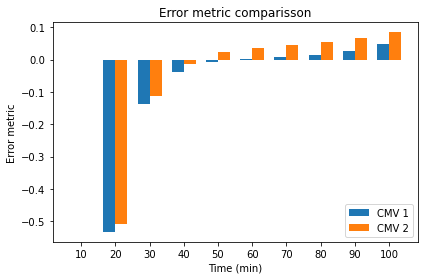

In [16]:
#Slice day in 70:100 to leave night time out

mean_error_cmv1 = np.mean(error_cmv1_array[70:100],axis=0)
mean_error_cmv2 = np.mean(error_cmv2_array[70:100],axis=0)


# visualization.barchart_compare3(mean_error_p, 'Persitence',
#                  mean_error_bp, 'Blurred Persitence',
#                  mean_error_cmv, 'CMV')

visualization.barchart_compare2(mean_error_cmv1, 'CMV 1',
                 mean_error_cmv2, 'CMV 2')
#barchart_compare(mean_error_cmv,mean_error_p)

In [8]:
#Testing for batch loading . Not working yet

current_imgs = []
predict_horizon = 10
files_total = len(os.listdir('data/images/dia_20'))

time_stamp = []
error_p_list = []

current_imgs, time_stamp, last_img_filename = data.load_by_batches(folder='data/images/dia_20', 
                                                          current_imgs=current_imgs, 
                                                          time_stamp= time_stamp, 
                                                          list_size= predict_horizon + 1, 
                                                          last_img_filename= None)

predictions_p, _ = model.persitence(current_imgs[0], time_stamp[0], predict_horizon)
predict_errors_p = evaluate.evaluate_image(predictions_p, current_imgs[1:], metric='RMSE')

error_p_list.append(predict_errors_p)

for _ in range():
    
    
    current_imgs, time_stamp, last_img_filename = data.load_by_batches(folder='data/images/dia_20', 
                                                            current_imgs=current_imgs, 
                                                            time_stamp= time_stamp, 
                                                            list_size= predict_horizon + 1, 
                                                            last_img_filename= last_img_filename)

TypeError: range expected 1 argument, got 0

In [50]:
visualization.save_errorarray_as_csv(error_cmv2_array,timestamp_20, 'prueba')

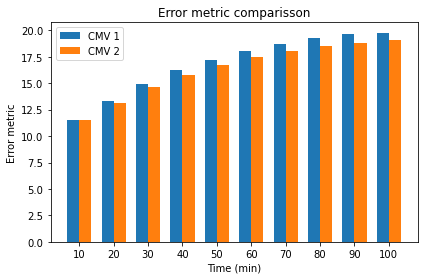

In [4]:
#Slice day in 70:100 to leave night time out

# mean_error_p = np.mean(error_p_array[70:100],axis=0)
# mean_error_bp = np.mean(error_bp_array[70:100],axis=0)
mean_error_cmv1 = np.mean(error_cmv1_array[70:100],axis=0)
mean_error_cmv2 = np.mean(error_cmv2_array[70:100],axis=0)


# visualization.barchart_compare3(mean_error_p, 'Persitence',
#                  mean_error_bp, 'Blurred Persitence',
#                  mean_error_cmv, 'CMV')

visualization.barchart_compare2(mean_error_cmv1, 'CMV 1',
                 mean_error_cmv2, 'CMV 2')
#barchart_compare(mean_error_cmv,mean_error_p)

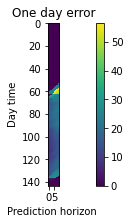

In [71]:
visualization.matrix_graph(error_p_array)
#visualization.matrix_graph(error_gp_array)

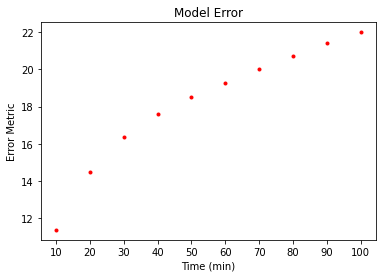

In [ ]:
visualization.plot_graph(mean_error_p)

In [9]:
def main_test(model_instance):
    images_day = images_20
    timestamp_day = timestamp_20
    predict_horizon = 30
    error_list =[]

    cmv_shift = 1 if isinstance(model_instance, model.Cmv) else 0
    for i in range(len(images_day)-cmv_shift):
        #set predict_horizon/ground_truths
        if (i < len(images_day)-predict_horizon-cmv_shift):
            predict_horizon_aux = predict_horizon
            ground_truths = images_day[i+cmv_shift:i+predict_horizon+1+cmv_shift]
        else: 
            predict_horizon_aux = len(images_day)-(i+1)-cmv_shift
            ground_truths = images_day[i+cmv_shift:]
        
        #predict depending on model
        if (isinstance(model_instance, model.Persistence)):
            predictions, _ = model_instance.predict(images_day[i], timestamp_day[i], predict_horizon_aux)
        elif (isinstance(model_instance, model.Cmv)):
            predictions = model_instance.predict(imgi=images_day[i], imgf=images_day[i+1], 
                period=10*60, delta_t=10*60, predict_horizon=predict_horizon_aux) 

        #evaluate
        predict_errors = evaluate.evaluate_image(predictions, ground_truths, 
            metric='RMSE',  pixel_max_value =255)

        for _ in range(predict_horizon+1 - len(predict_errors)):
            #puts 0 in errors for predictions outside the day
            predict_errors.append(0)

        error_list.append(predict_errors)
        
    print('Predicted for',len(error_list), 'images')
    error_array = np.array(error_list)
    print(error_array.shape)
    visualization.matrix_graph(error_array)

    # mean_error = np.mean(error_array[70:100],axis=0)
    # visualization.plot_graph(mean_error)


Predicted for 144 images
(144, 31)


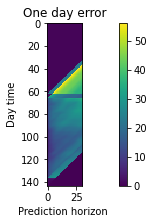

Predicted for 144 images
(144, 31)


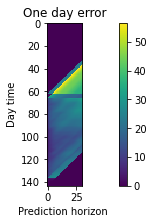

Predicted for 143 images
(143, 31)


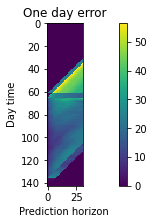

Predicted for 143 images
(143, 31)


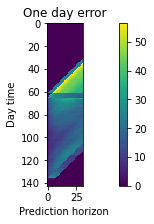

Predicted for 144 images
(144, 31)


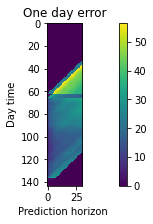

In [10]:
pers = model.Persistence()
persN = model.NoisyPersistence(sigma=1)
persB = model.BlurredPersistence(kernel_size=(11,11))
cmv1 = model.Cmv1()
cmv2 = model.Cmv2()

main_test(persN)
main_test(persB)
main_test(cmv1)
main_test(cmv2)
main_test(pers)